In [19]:
import numpy as np
import cse
import scipy.constants as const
from scipy.interpolate import splrep, splev
import matplotlib.pyplot as plt
import sys
import math

In [3]:
from scipy.integrate import quad

In [102]:
def Gv(v, we, wexe, weye, weze, weae=0):
    return we*(v+1/2) - wexe*(v+1/2)**2 + weye*(v+1/2)**3 + weze*(v+1/2)**4 + weae*(v+1/2)**5

def Bv(v, Be, ae, ge, de=0, ee=0):
    return Be - ae*(v+1/2) - ge*(v+1/2)**2 + de*(v+1/2)**3 + ee*(v+1/2)**4

def fIntegrand(vp, v):
    return 1/math.sqrt(Gv(v,we,wexe,weye,weze)-Gv(vp,we,wexe,weye,weze))

def gIntegrand(vp, v):
    return Bv(v,Be,ae,ge)/math.sqrt(Gv(v,we,wexe,weye,weze)-Gv(vp,we,wexe,weye,weze))

In [103]:
we=2358.57
wexe=14.324
weye=-2.26E-3
weze=-2.4E-4

Be=1.99824
ae=1.7318E-2
ge=-3.3E-5

In [151]:
mu=1.16294E-26
wavenumber_per_eV = 8065.6

In [105]:
def f(v):
    I = quad(fIntegrand,-1/2,v,args=(v))
    return 1/(2*const.pi*math.sqrt(2*mu*const.speed_of_light/const.Planck)) * I[0] * 1E8

def g(v):
    I = quad(gIntegrand,-1/2,v,args=(v))
    return 2*const.pi*math.sqrt(2*mu*const.speed_of_light/const.Planck) * I[0] * 1E-8

In [129]:
def r(v):
    fv=f(v)
    gv=g(v)
    return [math.sqrt(fv**2 + fv/gv)-fv, math.sqrt(fv**2 + fv/gv)+fv]

In [134]:
r(0)

[0.1055561942715914, 0.11461491293899788]

In [152]:
PES = []
for v in range(30):
    rv=r(v)
    Gvv=Gv(v,we,wexe,weye,weze)/wavenumber_per_eV
    PES.append([rv[0],Gvv])
    PES.append([rv[1],Gvv])
    
PES = np.asarray(PES)

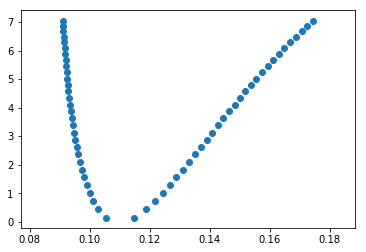

In [153]:
x, y = PES.T
plt.scatter(x,y)